In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd ./drive/MyDrive/Colab\ Notebooks/text_to_image_synthesis
!pwd

/content/drive/MyDrive/Colab Notebooks/text_to_image_synthesis
/content/drive/MyDrive/Colab Notebooks/text_to_image_synthesis


In [2]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from PIL import Image
import os
import sys

In [3]:
!cp './data/flowers.hdf5' '/content/flowers.hdf5'

## Import Generator and Discriminator Models

In [4]:
from models.gan_model import generator, discriminator

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
    print(f'Model is now running on a {torch.cuda.get_device_name()} GPU')
else:
    device = torch.device("cpu")

Model is now running on a Tesla T4 GPU


In [6]:
# Number of GPUs available. 
ngpu = torch.cuda.device_count()

# Create the generator
netG = generator().to(device)
netD = discriminator().to(device)

### Weights Initialization
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization

In [14]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
netG.apply(weights_init)
netD.apply(weights_init)

## Load Dataset

In [7]:
from utils.txt_to_image_dataloader import Text2ImageDataset

In [8]:
dataset_path = '/content/flowers.hdf5' # './data/birds.hdf5'
dataset = Text2ImageDataset(dataset_path)

## Parameters

In [9]:
# Size of z latent vector (i.e. size of generator input)
noise_dim = 100 

# Batch size during training
batch_size = 64

# Number of workers for dataloader
num_workers = 2

# Learning rate for optimizers
lr = 0.0002

# Number of training epochs
num_epochs = 20

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# L1 loss coefficient in the generator loss function
l1_coef = 50

# Feature matching coefficient in the generator loss function
l2_coef = 100

In [ ]:
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [10]:
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                         num_workers=num_workers)

## Training

In [ ]:
def smooth_label(tensor, offset):
    return tensor + offset

In [ ]:
hist_D = []
hist_G = []
hist_Dx = []
hist_DGx = []

In [ ]:
#cls: Boolean flag to whether train with cls algorithms or not. default=False
def train_gan(cls=False):
    criterion = nn.BCELoss()
    l2_loss = nn.MSELoss()
    l1_loss = nn.L1Loss()
    iteration = 0

    for epoch in range(num_epochs):
        for sample in data_loader:
            iteration += 1
            right_images = sample['right_images']
            right_embed = sample['right_embed']
            wrong_images = sample['wrong_images']

            right_images = Variable(right_images.float()).cuda()
            right_embed = Variable(right_embed.float()).cuda()
            wrong_images = Variable(wrong_images.float()).cuda()

            real_labels = torch.ones(right_images.size(0))
            fake_labels = torch.zeros(right_images.size(0))

            # ======== One sided label smoothing ==========
            # Helps preventing the discriminator from overpowering the
            # generator adding penalty when the discriminator is too confident
            # =============================================
            smoothed_real_labels = torch.FloatTensor(smooth_label(real_labels.numpy(), -0.1))

            real_labels = Variable(real_labels).cuda()
            smoothed_real_labels = Variable(smoothed_real_labels).cuda()
            fake_labels = Variable(fake_labels).cuda()

            # Train the discriminator
            netD.zero_grad()
            outputs, activation_real = netD(right_images, right_embed)
            real_loss = criterion(outputs, smoothed_real_labels)
            real_score = outputs

            if cls:
                outputs, _ = netD(wrong_images, right_embed)
                wrong_loss = criterion(outputs, fake_labels)
                wrong_score = outputs

            noise = Variable(torch.randn(right_images.size(0), 100)).cuda()
            noise = noise.view(noise.size(0), 100, 1, 1)
            fake_images = netG(right_embed, noise)
            outputs, _ = netD(fake_images, right_embed)
            fake_loss = criterion(outputs, fake_labels)
            fake_score = outputs

            d_loss = real_loss + fake_loss

            if cls:
                d_loss = d_loss + wrong_loss

            d_loss.backward()
            optimizerD.step()

            # Train the generator
            netG.zero_grad()
            noise = Variable(torch.randn(right_images.size(0), 100)).cuda()
            noise = noise.view(noise.size(0), 100, 1, 1)
            fake_images = netG(right_embed, noise)
            outputs, activation_fake = netD(fake_images, right_embed)
            _, activation_real = netD(right_images, right_embed)

            activation_fake = torch.mean(activation_fake, 0)
            activation_real = torch.mean(activation_real, 0)


            #======= Generator Loss function============
            # This is a customized loss function, the first term is the regular cross entropy loss
            # The second term is feature matching loss, this measure the distance between the real and generated
            # images statistics by comparing intermediate layers activations
            # The third term is L1 distance between the generated and real images, this is helpful for the conditional case
            # because it links the embedding feature vector directly to certain pixel values.
            #===========================================
            g_loss = criterion(outputs, real_labels) \
                      + l2_coef * l2_loss(activation_fake, activation_real.detach()) \
                      + l1_coef * l1_loss(fake_images, right_images)

            g_loss.backward()
            optimizerG.step()

            if iteration % 5 == 0:

                hist_D.append(d_loss.data.cpu().mean())
                hist_G.append(g_loss.data.cpu().mean())
                hist_Dx.append(real_score.data.cpu().mean())
                hist_DGx.append(fake_score.data.cpu().mean())
                # self.logger.log_iteration_gan(epoch,d_loss, g_loss, real_score, fake_score)
                # self.logger.draw(right_images, fake_images)
                f = f'[ {epoch}/{num_epochs}][{iteration}/{len(data_loader)}] \tLoss_D: {d_loss}\tLoss_G: {g_loss}' 
                sys.stdout.write("\r" + str(f))
                sys.stdout.flush()
        # self.logger.plot_epoch_w_scores(epoch)

        # if (epoch) % 10 == 0:
            # Utils.save_checkpoint(self.discriminator, self.generator, self.checkpoints_path, self.save_path, epoch)

In [ ]:
train_gan()

[ 19/20][9200/460] 	Loss_D: 0.4774744510650635	Loss_G: 29.77812385559082

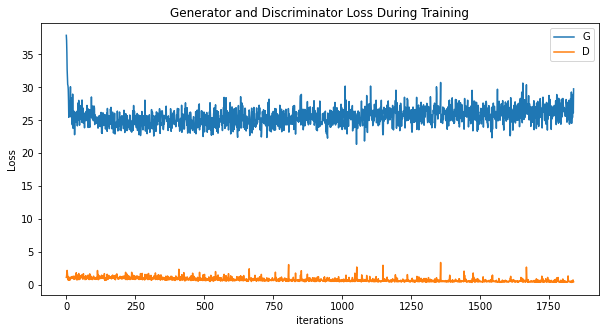

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(hist_G,label="G")
plt.plot(hist_D,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

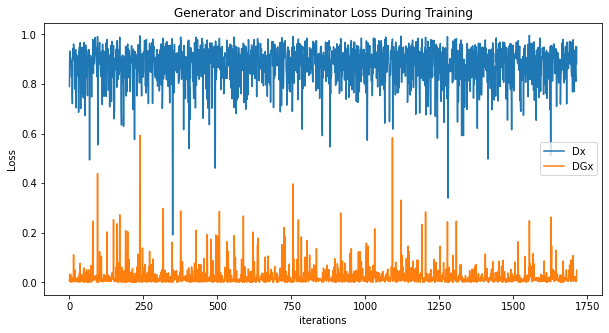

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(hist_Dx,label="Dx")
plt.plot(hist_DGx,label="DGx ")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# torch.save(netG.state_dict(), './models/txt2img_netG_flowers_e20')
# torch.save(netD.state_dict(), './models/txt2img_netD_flowers_e20') 

In [11]:
netG.load_state_dict(torch.load('./models/txt2img_netG_flowers_e20'))
netD.load_state_dict(torch.load('./models/txt2img_netD_flowers_e20'))

<All keys matched successfully>

64


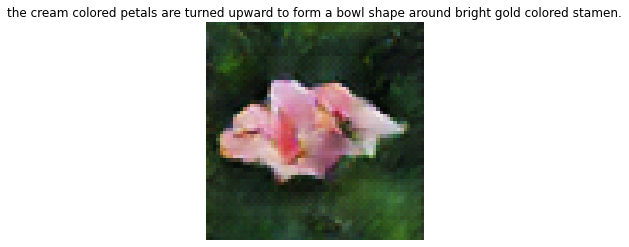

In [ ]:
import matplotlib.pyplot as plt

save_path = './'
 
for sample in data_loader:
    right_images = sample['right_images']
    right_embed = sample['right_embed']
    txt = sample['txt']
    # print(txt)
    if not os.path.exists('results/{0}'.format(save_path)):
        os.makedirs('results/{0}'.format(save_path))

    right_images = Variable(right_images.float()).cuda()
    right_embed = Variable(right_embed.float()).cuda()

    # Train the generator
    noise = Variable(torch.randn(right_images.size(0), 100)).cuda()
    noise = noise.view(noise.size(0), 100, 1, 1)
    fake_images = netG(right_embed, noise)
    print(right_images.size(0))
    # self.logger.draw(right_images, fake_images)

    for image, t in zip(fake_images, txt):
        im = Image.fromarray(image.data.mul_(127.5).add_(127.5).byte().permute(1, 2, 0).cpu().numpy())
        #im.save('results/{0}/[60]{1}.jpg'.format(save_path, t.replace("/", "")[:100]))
        # print(t)
        plt.figure( )
        plt.axis("off")
        plt.title(t)
        plt.imshow(im)
        break
    break

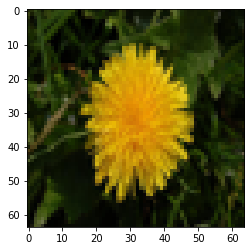

In [ ]:
im = Image.fromarray(right_images[0].data.mul_(127.5).add_(127.5).byte().permute(1, 2, 0).cpu().numpy())
plt.imshow(im)

In [ ]:
txt[0], right_embed[0]

('a dark brown long flower with a golden pedals attached to it.',
 tensor([-0.0170,  0.2231, -0.0053,  ..., -0.0413,  0.0678,  0.0401],
        device='cuda:0'))

In [12]:
pip install torchfile

In [13]:
from utils.text_utils import prepare_text
from utils.utils_char_cnn_rnn import extract_char_cnn_rnn_weights


# extract weights from original models
net_state_dict = extract_char_cnn_rnn_weights( './models/lm_sje_flowers_c10_hybrid_0.00070_1_10_trainvalids.txt_iter16400.t7', 'flowers', 'icml')

In [14]:
from models.char_cnn_rnn import char_cnn_rnn

# create Char-CNN-RNN model and load weights
net = char_cnn_rnn()
#net.load_state_dict(torch.load(args.weights_out_path))
net.load_state_dict(net_state_dict)
net = net.to(device)
net.eval()
print(net)

char_cnn_rnn(
  (conv1): Conv1d(70, 384, kernel_size=(4,), stride=(1,))
  (threshold1): Threshold(threshold=1e-06, value=0)
  (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(384, 512, kernel_size=(4,), stride=(1,))
  (threshold2): Threshold(threshold=1e-06, value=0)
  (maxpool2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(512, 512, kernel_size=(4,), stride=(1,))
  (threshold3): Threshold(threshold=1e-06, value=0)
  (maxpool3): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rnn): fixed_rnn(
    (i2h): Linear(in_features=512, out_features=512, bias=True)
    (h2h): Linear(in_features=512, out_features=512, bias=True)
  )
  (emb_proj): Linear(in_features=512, out_features=1024, bias=True)
)


To use your trained model, call model.eval() to disable further training. This stops BatchNorm layers from updating their mean and variance, and allows input of just one sample. Use model.train() to resume training mode, if needed.

In [15]:
netG.eval()

generator(
  (projection): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (netG): Sequential(
    (0): ConvTranspose2d(228, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)


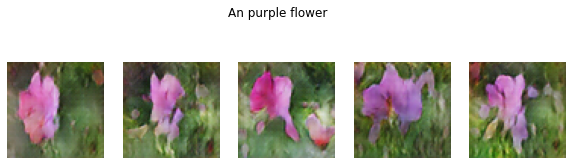

In [17]:
import matplotlib.pyplot as plt

# captionText = 'Anything but a flower please'
captionText = 'An purple flower'

caption = prepare_text(captionText)
caption = caption.unsqueeze(0).to(device)

embed = net(caption).to(device)
# embed = Variable(embed.float()).to(device)
# print(out.shape)


# Create figure with 1 subplot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))
fig.suptitle(captionText)


 

for a in axs:

  # Train the generator
  noise = Variable(torch.randn(1, 100)).cuda()
  noise = noise.view(noise.size(0), 100, 1, 1)

  fake_image = netG(embed, noise)
  im = Image.fromarray(fake_image[0].data.mul_(127.5).add_(127.5).byte().permute(1, 2, 0).cpu().numpy())

  a.imshow(im)
  a.axis("off")

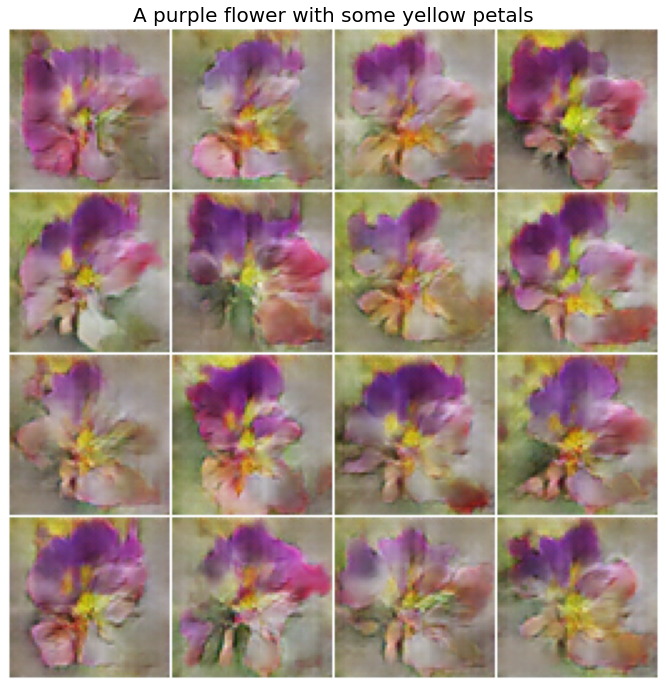

In [19]:
import matplotlib.pyplot as plt

# captionText = 'Anything but a flower please'
captionText = 'A purple flower with some yellow petals'

caption = prepare_text(captionText)
caption = caption.unsqueeze(0).to(device)

embed = net(caption).to(device)
embed = Variable(embed.float()).to(device)
 

 
img_list = []
for i in range(16):
  if i>0:
    prev = img
  # Train the generator
  noise = Variable(torch.randn(1, 100)).cuda()
  noise = noise.view(noise.size(0), 100, 1, 1)

  fake_image = netG(embed, noise)
  
  img = fake_image.data.mul_(127.5).add_(127.5).byte()
  if i > 0:
    img = torch.cat((prev,img))

import torchvision

fig = plt.figure(  figsize=(12, 12))

plt.title(captionText, fontsize=20)
plt.axis('off')
plt.imshow(torchvision.utils.make_grid(img.cpu(), nrow=4, padding=1,pad_value = 255).permute(1, 2, 0))